# Stroke Prediction Analysis for Government Awareness Campaign

## Introduction
In this notebook, we'll use the healthcare stroke dataset from Kaggle [more info about dataset here] to discern the factors that increase a person's likelihood of experiencing a stroke. We will perform [xyz models] to perform an inference analysis on the dataset. 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold,\
cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,\
classification_report, make_scorer, recall_score, mean_squared_error
from sklearn.metrics import roc_auc_score as ras
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,\
StandardScaler, MinMaxScaler, normalize
from imblearn.over_sampling import SMOTE, RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

## Importing and previewing the dataset

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Before we start, we'll drop the id column, as that provides no value to our analysis. 

In [3]:
df.drop("id", axis=1, inplace=True)

In total, there are 10 predictors, and one outcome variable, stroke - 1 for yes and 0 for no.

The 10 predictors are:

- `gender`: Female, Male 

- `age`: Continuous

- `hypertension`: 0, 1

- `heart_disease`: 0, 1

- `ever_married`: Yes, No

- `work_type`: Private, Self-employed, children, Govt_job, Never_worked

- `Residence_type`: Urban, Rural

- `avg_glucose_level`: Continuous

- `bmi`: Continuous, including some NaN values

- `smoking_status`: never smoked, Unknown, formerly smoked, smokes


We'll start by encoding the categorical data. Since the categorical columns are nominal, meaning the categories are not hierarchical, we'll use one-hot-encoding. After encoding the categorical columns, we'll address the NaN values in the bmi column by using simple_imputer to replace null values with the predicted K nearest neighbor (KNN) value. 

In [4]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
df["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

It doesn't make sense to create a new category for "Other" since only one person identified as that, so we'll drop it. 

In [6]:
# LabelEncoder
df = df[df["gender"]!="Other"]
df["gender"].value_counts()

gender
Female    2994
Male      2115
Name: count, dtype: int64

In [7]:
df.shape

(5109, 11)

(array([1025., 1291., 1565., 1228.]),
 array([8.000e-02, 2.056e+01, 4.104e+01, 6.152e+01, 8.200e+01]),
 <BarContainer object of 4 artists>)

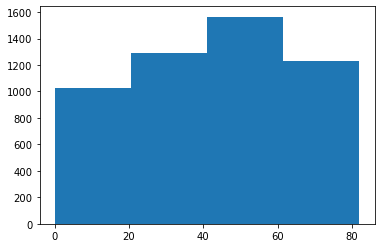

In [8]:
plt.hist(df["age"], bins=4)

In [9]:
# df.drop("age", axis=1, inplace=True)

In [10]:
# OHE
df["ever_married"].value_counts()

ever_married
Yes    3353
No     1756
Name: count, dtype: int64

In [11]:
# OHE
df["Residence_type"].value_counts()

Residence_type
Urban    2596
Rural    2513
Name: count, dtype: int64

In [12]:
# OHE
df["work_type"].value_counts()

work_type
Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [13]:
# OHE
df["smoking_status"].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

In [14]:
df.select_dtypes(include=['object']).head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [15]:
# pd.get_dummies(data, prefix = "work_type", drop_first=True, dtype=int)
categorical = df.select_dtypes(include=['object'])

ohe = OneHotEncoder(drop='first')
ohe.fit(categorical)
categorical_encoded = pd.DataFrame(ohe.transform(categorical).todense(),
                               columns=ohe.get_feature_names_out())
categorical_encoded

,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5104,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
5105,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5106,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5107,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
df_numeric = df.select_dtypes("number")
df_numeric.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,NaN,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


In [17]:
# df_numeric.drop("stroke", axis=1, inplace=True)

In [18]:
df_new = pd.concat([categorical_encoded.reset_index(), df_numeric.reset_index()], axis=1)
df_new.drop("index", axis=1, inplace=True)
df_new.head()

,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,67.0,0,1,228.69,36.6,1
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,61.0,0,0,202.21,NaN,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0,1,105.92,32.5,1
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,49.0,0,0,171.23,34.4,1
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,79.0,1,0,174.12,24.0,1


Now that the dataset is all numeric, we can use the KNNImputer tool to replace the null values in the BMI column. This should give us a better result than simply using the mean, median, or most frequent.

In [19]:
# Split the data into features and target
X = df_new.drop('bmi', axis=1)
y = df_new['bmi']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the KNNImputer and grid search
param_grid = {'n_neighbors': [1, 2, 3, 4, 5]}
knn_imputer = KNNImputer()
grid_search = GridSearchCV(knn_imputer, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters, including the best number of neighbors (k)
best_params = grid_search.best_params_
best_neighbors = best_params['n_neighbors']

# Print the best parameters
print("Best Parameters:")
print(best_params)

Best Parameters:
{'n_neighbors': 1}


In [20]:
knn_imputer = KNNImputer(n_neighbors=1)  # Adjust the number of neighbors as needed

# Impute missing values in the DataFrame
df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_new), columns=df_new.columns)

In [21]:
df_imputed.isnull().values.any()

False

In [22]:
df_imputed.shape

(5109, 16)

The last thing we should do is check for multicollinearity. If two features are too correlated, it will be difficult to determine which feature is impacting our results. Below, we check to see if any columns are <70% correlated.

In [23]:
# Handling multicollinearity

columns = list(df_imputed.columns)
for col in columns:
    if col == 'stroke':
        continue

    filtered_columns = [col]
    for col1 in df_imputed.columns:
        if((col == col1) | (col == 'stroke')):
            continue

        val = df_imputed[col].corr(df_imputed[col1])

        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df_imputed[filtered_columns]
df.shape

(5109, 16)

Our dimensions remain the same which means there were no feature correlations above our 70% threshold. We can begin training our models.

## Model Training

Now that the dataset is cleaned, we can begin comparing the performance of various models. Since this is a binary classification problem, we'll try the following models:
- Logistic regression
- K Nearest Neighbor classifier
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost
- Support vector machine (SVM)

We'll also compare SMOTE to RandomOverSampler on our minority class and create a more balanced dataset for our target variable. This should help our model better predict when someone has actually experienced a stroke.

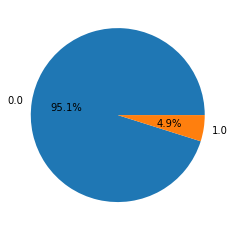

In [24]:
target_dist = df['stroke'].value_counts()
plt.pie(target_dist.values,
        labels = target_dist.index,
        autopct='%1.1f%%')
plt.show()

In [25]:
features = df.drop('stroke', axis=1)
target = df['stroke']
 
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

X_train.shape, X_val.shape

((4087, 15), (1022, 15))

### Model Selection

In [26]:
recall_scores= []

smote = SMOTE(random_state=0)
ros = RandomOverSampler(sampling_strategy='minority', random_state=0)

oversampling_techniques = [smote, ros]

for technique in oversampling_techniques:
    
    print(f'{technique} : ')
    print("___________________________________________")
    
    X_resampled, Y_resampled = technique.fit_resample(X_train, Y_train)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_val_scaled = scaler.transform(X_val)

    X_train_scaled.shape, Y_resampled.shape


    models = [LogisticRegression(), 
              DecisionTreeClassifier(), 
              RandomForestClassifier(), 
              KNeighborsClassifier(), 
              SVC(kernel='rbf', probability=True),
              XGBClassifier()]

    for model in models:
        model.fit(X_train_scaled, Y_resampled)

        print(f'{model} : ')

        train_preds_proba = model.predict_proba(X_train_scaled)[:, 1]
        print('Training ROC AUC Score : ', ras(Y_resampled, train_preds_proba))

        val_preds_proba = model.predict_proba(X_val_scaled)[:, 1]
        print('Validation ROC AUC Score : ', ras(Y_val, val_preds_proba))
        print()

        train_preds = model.predict(X_train_scaled)
        print('Training Accuracy : ', ras(Y_resampled, train_preds))

        val_preds = model.predict(X_val_scaled)
        print('Validation Accuracy : ', ras(Y_val, val_preds))
        print()

        conf_matrix = confusion_matrix(Y_val, val_preds, normalize='true')

        print("Confusion Matrix:")
        print(conf_matrix)

        test_recall = recall_score(Y_val, val_preds)
        recall_scores.append(test_recall)
        print(f"Recall: {test_recall}")

        print("")
        print("----------------------")
        print("")

SMOTE(random_state=0) : 
___________________________________________
LogisticRegression() : 
Training ROC AUC Score :  0.8538353740114143
Validation ROC AUC Score :  0.8374279835390946

Training Accuracy :  0.785108024691358
Validation Accuracy :  0.7698559670781893

Confusion Matrix:
[[0.73971193 0.26028807]
 [0.2        0.8       ]]
Recall: 0.8

----------------------

DecisionTreeClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.5827366255144033

Training Accuracy :  1.0
Validation Accuracy :  0.5827366255144033

Confusion Matrix:
[[0.94547325 0.05452675]
 [0.78       0.22      ]]
Recall: 0.22

----------------------

RandomForestClassifier() : 
Training ROC AUC Score :  1.0
Validation ROC AUC Score :  0.7634259259259258

Training Accuracy :  1.0
Validation Accuracy :  0.5274279835390947

Confusion Matrix:
[[0.99485597 0.00514403]
 [0.94       0.06      ]]
Recall: 0.06

----------------------

KNeighborsClassifier() : 
Training ROC AUC Score :  0.9982494014

Our logistic regression model using SMOTE seems to be fitting the best with regard to **accuracy (78.5% training, 76.9% validation)** and **recall (80%)** so we'll use that model. 

In [27]:
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_val_scaled = scaler.transform(X_val)

X_train_scaled.shape, Y_resampled.shape

((7776, 15), (7776,))

## Picking the best model

Given our business problem -- performing inferential statistics on stroke patients for a government awareness campaign -- we are mostly interested in patients **who HAVE experienced a stroke**. Therefore, the best model for us appears to be the **logistic regression model**. Let's finally tune the model using grid_search to get the optimal parameters for recall, while maintaining a good accuracy score. 

In [28]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}

# Define the scoring metrics (recall and accuracy)
scoring = {
    'Accuracy': make_scorer(accuracy_score),
    'Recall': make_scorer(recall_score)
}

# Create the GridSearchCV object
lr_model = LogisticRegression() 
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='Recall',  # Refit based on Recall
    cv=10,  # Number of cross-validation folds
)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, Y_resampled)

# Print the best parameters and corresponding scores for both accuracy and recall
print("Best Parameters (Recall):", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Access the accuracy results
accuracy_results = grid_search.cv_results_['mean_test_Accuracy']
print("Best Parameters (Accuracy):", param_grid["C"][accuracy_results.argmax()])
print("Best Accuracy Score:", accuracy_results.max())

# Evaluate the model on the test set using the best parameters for recall
best_model_recall = grid_search.best_estimator_
y_pred_recall = best_model_recall.predict(X_val_scaled)
test_recall = recall_score(Y_val, y_pred_recall)
print("Test Recall Score:", test_recall)

# Evaluate the model on the test set using the best parameters for accuracy
best_model_accuracy = grid_search.best_estimator_
y_pred_accuracy = best_model_accuracy.predict(X_val_scaled)
test_accuracy = accuracy_score(Y_val, y_pred_accuracy)
print("Test Accuracy Score:", test_accuracy)

Best Parameters (Recall): {'C': 0.001, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score: 0.8629130999390453
Best Parameters (Accuracy): 0.001
Best Accuracy Score: nan
Test Recall Score: 0.84
Test Accuracy Score: 0.6868884540117417


In [29]:
best_model = LogisticRegression(
    penalty='l1',
    C=0.001,
    class_weight=None,
    max_iter=100,
    solver='liblinear',
    random_state=42 
)

# Fit the model to your entire training dataset
best_model.fit(X_train_scaled, Y_resampled)

# using best_recall_model for predictions on new data
y_pred = best_model.predict(X_val_scaled)
y_pred_train = best_model.predict(X_train_scaled)
test_recall = recall_score(Y_val, y_pred)
train_accuracy = accuracy_score(Y_resampled, y_pred_train)
test_accuracy = accuracy_score(Y_val, y_pred)
conf_matrix = confusion_matrix(Y_val, y_pred)

print(f"Recall: {test_recall}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.84
Train Accuracy: 0.7700617283950617
Test Accuracy: 0.6868884540117417
Confusion Matrix:
[[660 312]
 [  8  42]]


Tuning our parameters increased our recall by 4% and our model now correctly predicts 84% of the stroke patients, while still predicting a significant amount of non-stroke patients. With this model, we can start learning more about what factors are correlated to strokes.

## Feature importance

In [30]:
# Retrieve the coefficients and feature names
coefficients = best_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to display the coefficients and feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort the DataFrame by the absolute value of coefficients to highlight the most impactful features
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the feature importance DataFrame
print("Feature Importance:")
feature_importance_df

Feature Importance:


,Feature,Coefficient,Odds Ratio
11,age,0.748417,2.113652
0,bmi,0.000000,1.000000
1,gender_Male,0.000000,1.000000
2,ever_married_Yes,0.000000,1.000000
3,work_type_Never_worked,0.000000,1.000000
4,work_type_Private,0.000000,1.000000
5,work_type_Self-employed,0.000000,1.000000
6,work_type_children,0.000000,1.000000
7,Residence_type_Urban,0.000000,1.000000
8,smoking_status_formerly smoked,0.000000,1.000000


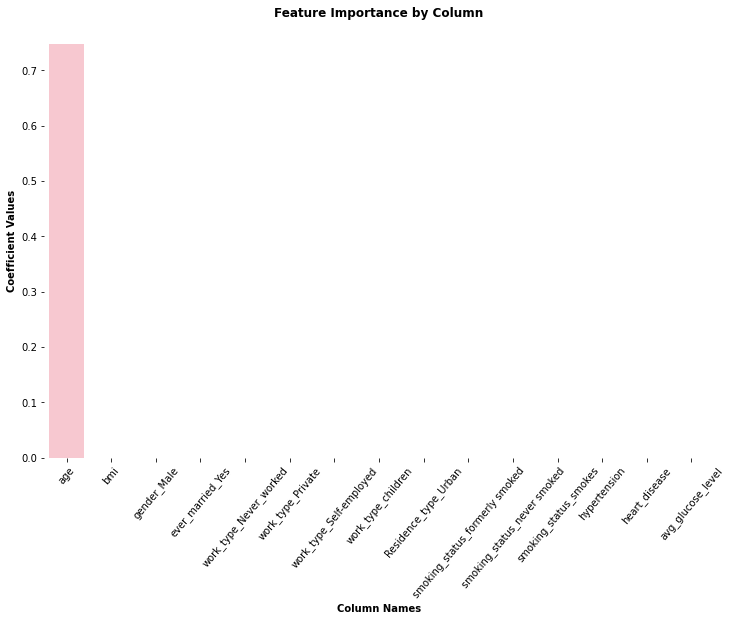

In [31]:
import seaborn as sns

x=feature_importance_df['Feature']
y=feature_importance_df['Coefficient']

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['pink' if _y >=0 else 'red' for _y in y]
ax = sns.barplot(x, y, palette=colors)

ax.set_ylabel("Coefficient Values", fontweight='bold')
ax.set_xlabel("Column Names", fontweight='bold')
ax.set_title("Feature Importance by Column", fontweight='bold')
ax.tick_params (axis='x', labelrotation=50)

sns.despine(ax=ax, bottom=True, left=True)
plt.show()

This is disappointing. Our tuned model is not generalized enough, and only uses the strongest correlated feature, age. Let's go back to the base model. 

In [32]:
lr_model = LogisticRegression()

# Fit the model to your entire training dataset
lr_model.fit(X_train_scaled, Y_resampled)

# using best_recall_model for predictions on new data
y_pred = lr_model.predict(X_val_scaled)
y_pred_train = lr_model.predict(X_train_scaled)
test_recall = recall_score(Y_val, y_pred)
train_accuracy = accuracy_score(Y_resampled, y_pred_train)
test_accuracy = accuracy_score(Y_val, y_pred)
conf_matrix = confusion_matrix(Y_val, y_pred)

print(f"Recall: {test_recall}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Recall: 0.8
Train Accuracy: 0.785108024691358
Test Accuracy: 0.7426614481409002
Confusion Matrix:
[[719 253]
 [ 10  40]]


In [33]:
# Retrieve the coefficients and feature names
coefficients = lr_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame to display the coefficients and feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds Ratio': np.exp(coefficients)
})

# Sort the DataFrame by the absolute value of coefficients to highlight the most impactful features
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the feature importance DataFrame
print("Feature Importance:")
feature_importance_df

Feature Importance:


,Feature,Coefficient,Odds Ratio
11,age,1.932769,6.908611
12,hypertension,0.260568,1.297667
14,avg_glucose_level,0.236312,1.266569
6,work_type_children,0.187855,1.206658
3,work_type_Never_worked,-0.173069,0.841080
10,smoking_status_smokes,0.171320,1.186871
5,work_type_Self-employed,-0.160860,0.851412
7,Residence_type_Urban,0.092704,1.097137
9,smoking_status_never smoked,-0.082595,0.920724
8,smoking_status_formerly smoked,0.055991,1.057588


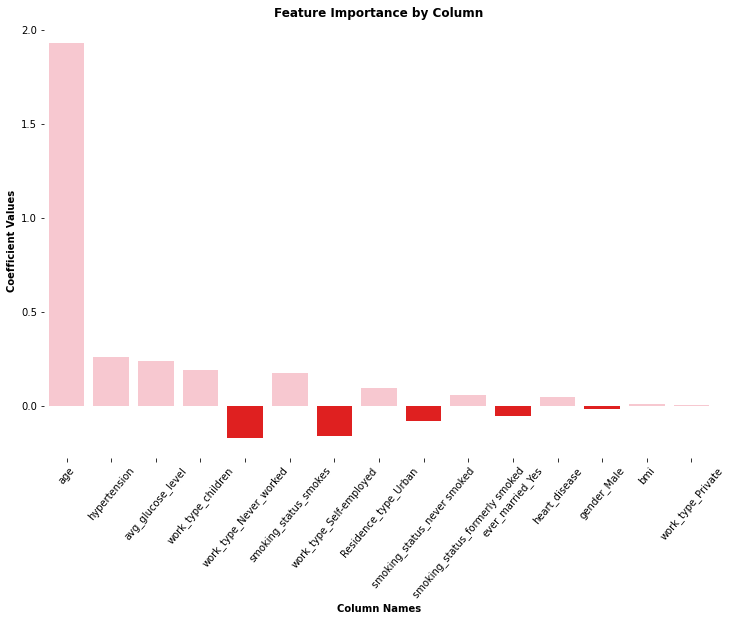

In [34]:
import seaborn as sns

x=feature_importance_df['Feature']
y=feature_importance_df['Coefficient']

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['pink' if _y >=0 else 'red' for _y in y]
ax = sns.barplot(x, y, palette=colors)

ax.set_ylabel("Coefficient Values", fontweight='bold')
ax.set_xlabel("Column Names", fontweight='bold')
ax.set_title("Feature Importance by Column", fontweight='bold')
ax.tick_params (axis='x', labelrotation=50)

sns.despine(ax=ax, bottom=True, left=True)
plt.show()

In [35]:
val_probs = lr_model.predict_proba(X_val_scaled)[:, 1]
val_probs = pd.DataFrame(val_probs, columns=["predictions"])

In [36]:
df_results = pd.concat([X_val.reset_index(), val_probs.reset_index()], axis=1)
df_results.drop("index", axis=1, inplace=True)
df_results.groupby(["gender_Male", "ever_married_Yes"]).mean()

bmi  work_type_Never_worked  \
gender_Male ever_married_Yes                                      
0.0         0.0               25.877941                0.014706   
            1.0               30.661832                0.000000   
1.0         0.0               25.244444                0.018519   
            1.0               31.155513                0.000000   

                              work_type_Private  work_type_Self-employed  \
gender_Male ever_married_Yes                                               
0.0         0.0                        0.549020                 0.049020   
            1.0                        0.608142                 0.211196   
1.0         0.0                        0.444444                 0.080247   
            1.0                        0.673004                 0.186312   

                              work_type_children  Residence_type_Urban  \
gender_Male ever_married_Yes                                             
0.0         0.0                         0.318627              0.563725   
            1.0                         0.000000              0.508906   
1.0         0.0                         0.413580              0.561728   
            1.0                         0.000000              0.517110   

                              smoking_status_formerly smoked  \
gender_Male ever_married_Yes                                   
0.0         0.0                                     0.068627   
            1.0                                     0.190840   
1.0         0.0                                     0.104938   
            1.0                                     0.239544   

                              smoking_status_never smoked  \
gender_Male ever_married_Yes                                
0.0         0.0                                  0.328431   
            1.0                                  0.450382   
1.0         0.0                                  0.228395   
            1.0                                  0.346008   

                              smoking_status_smokes        age  hypertension  \
gender_Male ever_married_Yes                                                   
0.0         0.0                            0.147059  24.129412      0.039216   
            1.0                            0.185751  53.732824      0.127226   
1.0         0.0                            0.098765  21.880000      0.030864   
            1.0                            0.205323  55.045627      0.182510   

                              heart_disease  avg_glucose_level  predictions  
gender_Male ever_married_Yes                                                 
0.0         0.0                    0.014706          97.474216     0.122815  
            1.0                    0.033079         110.121476     0.418206  
1.0         0.0                    0.024691          98.058704     0.113433  
            1.0                    0.091255         115.703764     0.450901

In [39]:
df_results['age'].min(), df_results['age'].max()

(0.08, 82.0)

(array([ 92.,  69.,  82., 102., 120., 118., 134., 124.,  66., 115.]),
 array([8.0000e-02, 8.2720e+00, 1.6464e+01, 2.4656e+01, 3.2848e+01,
        4.1040e+01, 4.9232e+01, 5.7424e+01, 6.5616e+01, 7.3808e+01,
        8.2000e+01]),
 <BarContainer object of 10 artists>)

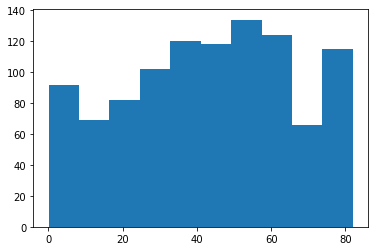

In [38]:
plt.hist(df_results["age"])

We could also try dropping age from our dataset to increase the importance of the other features. 